### Sentiment Analysis

The objective of this homework assignment is to showcase proficiency in utilizing an established sentiment analysis model and refining it to achieve improved performance.

Your tasks for this assignment:

1. Visualize the dataset
2. Split the data into training and validation sets
3. Utilize PyTorch datasets to load the data
4. Establish a baseline model
5. Fine tune a model
6. Compare results between fine-tuned and baseline



In [3]:
# Import necessary modules; this serves as a starting point, and depending on your implementation, 
# you may require additional or fewer modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader


from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, get_scheduler, pipeline

from tqdm.auto import tqdm

import evaluate


2024-05-09 06:02:46.091370: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-09 06:02:46.289513: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-09 06:02:46.289550: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-09 06:02:46.341479: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-09 06:02:46.353349: I tensorflow/core/platform/cpu_feature_guar

2024-05-09 06:02:51.537796: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


1. **Visualize the dataset**
   - Plot the distribution of labels to assess balance.
   - Visualize sample data points to understand the format and characteristics of the dataset.
   - Explore the distribution of text lengths.


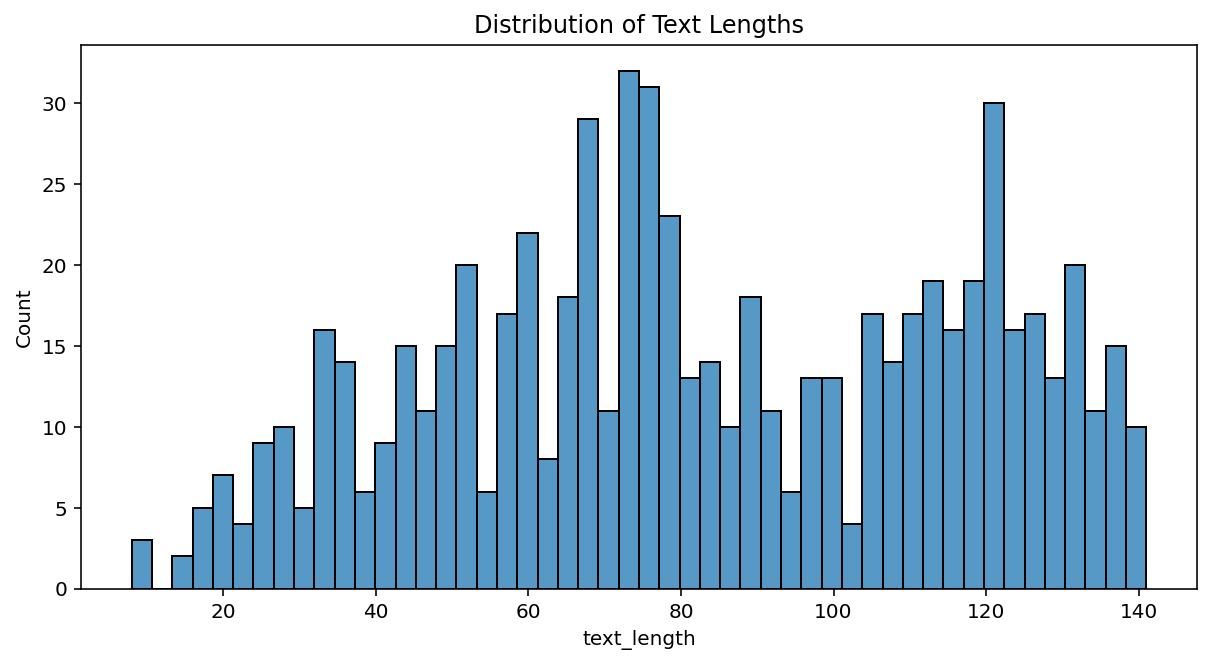

In [4]:
data = pd.read_csv("train_data.csv")

import seaborn as sns

# distribution of text lengths
data['text_length'] = data['text'].apply(len)
plt.figure(figsize=(10, 5))
sns.histplot(data['text_length'], bins=50)
plt.title('Distribution of Text Lengths')
plt.show()

**Disclaimer:** The tweets presented here were collected from various sources and are intended to showcase the diversity of content found on social media platforms. They do not necessarily reflect the views or values of this class. Furthermore, please note that the tweets have been prelabeled, which may introduce inaccuracies or biases in the labeling process.



In [5]:
data.head()

,ID,labels,text,text_length
0,314960726,Negative,This weather on some bullshit .,31
1,314960390,Negative,"@mention good crowd in Wrigley today, terrible...",135
2,314961089,Negative,First and last time walking to a class on Frid...,88
3,314960518,Negative,My room is freezing :/ or im jus too cold :S,44
4,314960427,Negative,@mention storm? Be safe! The weather has been ...,59


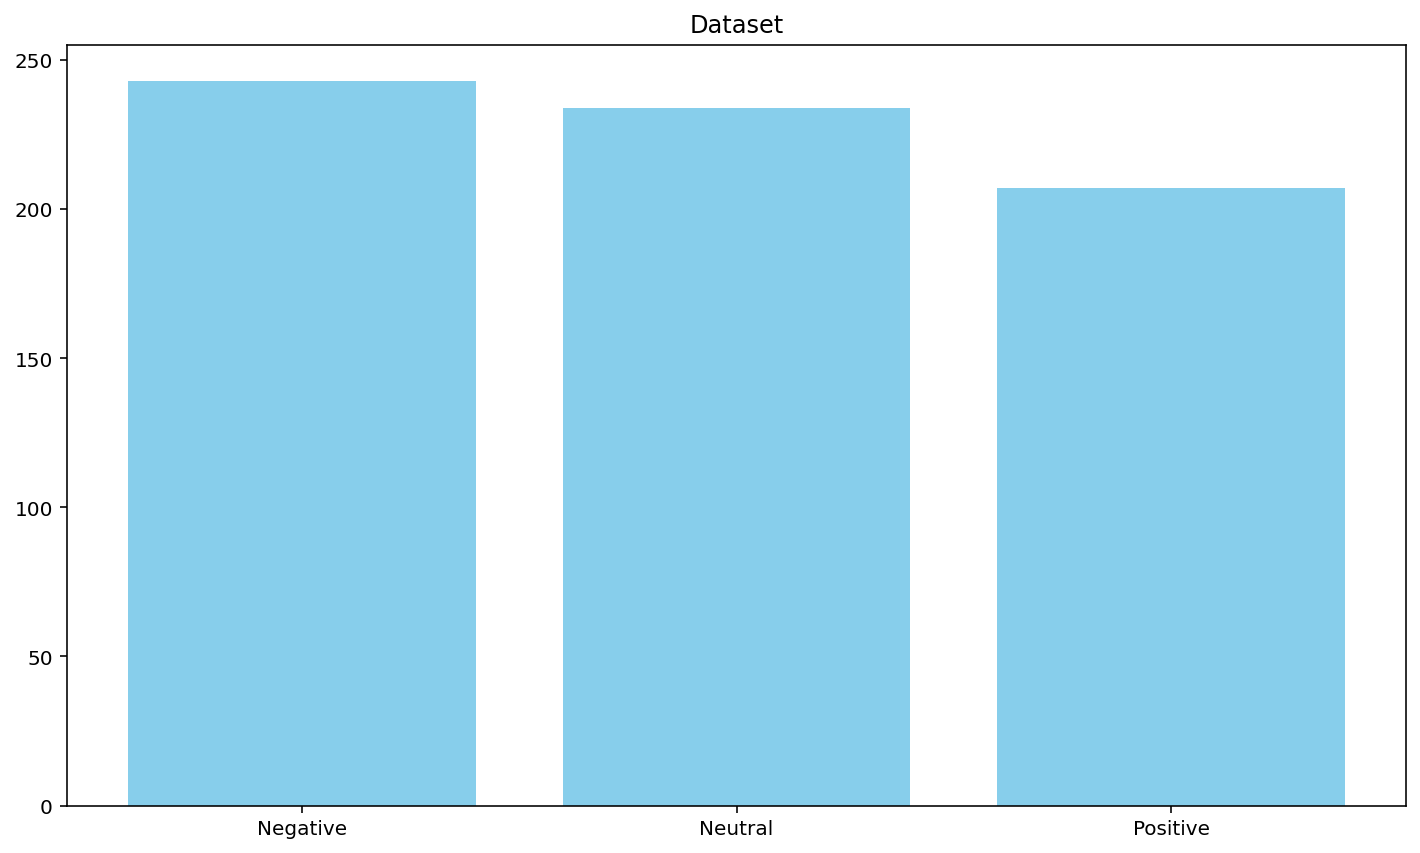

In [6]:
categories = data['labels'].unique()
data_counts = data['labels'].value_counts()
plt.bar(categories, data_counts, color='skyblue')
plt.title('Dataset')

plt.show()

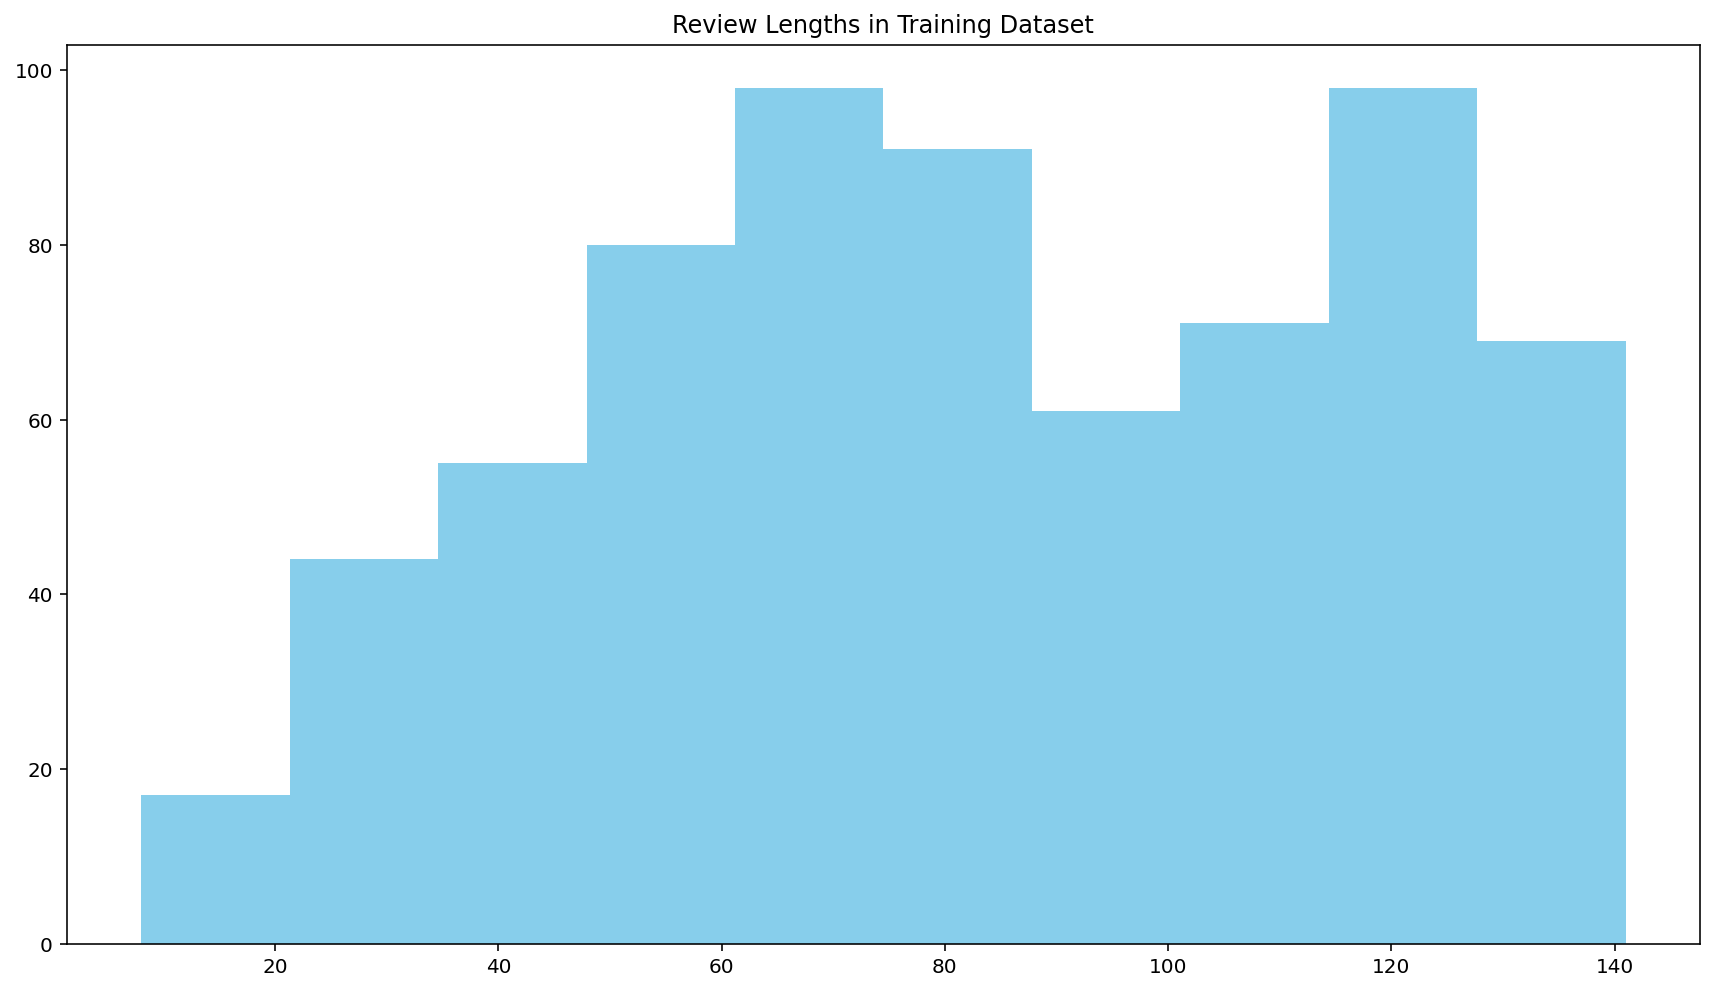

In [7]:
text_lengths = [len(review) for review in data['text']]

plt.hist(text_lengths, color = 'skyblue')
plt.title('Review Lengths in Training Dataset')

plt.tight_layout()
plt.show()

2. **Split the data into training and validation dataframes:**
   - Determine the desired ratio or size for the training and validation sets.
   - Randomly shuffle the dataset to ensure a representative split.
   - Separate the data into training and validation subsets.

In [8]:

# Shuffle the dataset
df_shuffled = data.sample(frac=1, random_state=42)  # random_state for reproducibility

# Group by labels
grouped = df_shuffled.groupby('labels')

# Split each group while maintaining balance
train_dfs = []
val_dfs = []
for label, group in grouped:
    train, val = train_test_split(group, test_size=0.1, random_state=42)  # 80% train, 20% validation
    train_dfs.append(train)
    val_dfs.append(val)

# Combine split groups back into separate datasets
train_df = pd.concat(train_dfs)
val_df = pd.concat(val_dfs)

# Reset index for consistency
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

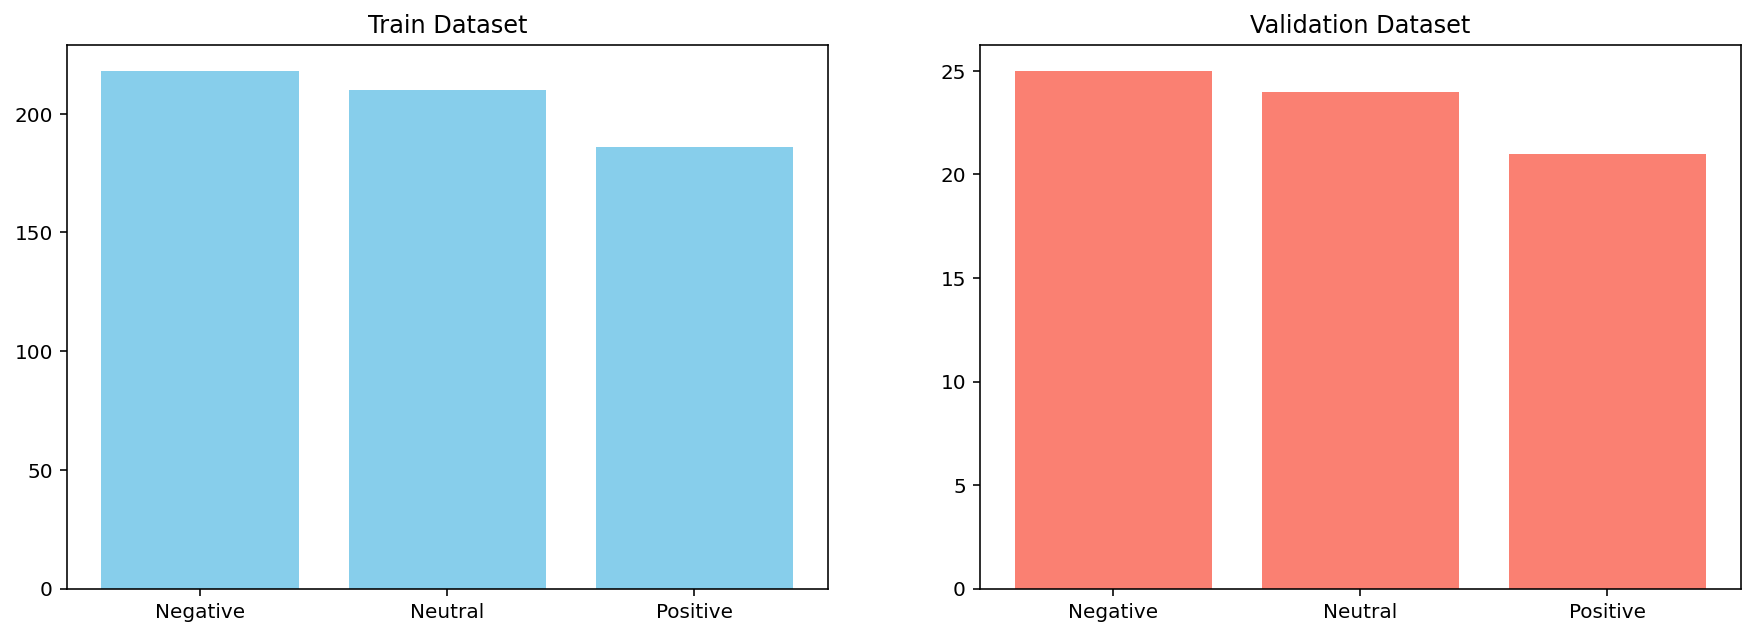

In [9]:
#Get Negative and Positive Counts
train_categories = train_df['labels'].unique()
train_counts = train_df['labels'].value_counts() 
valid_categories = val_df['labels'].unique()
valid_counts = val_df['labels'].value_counts() 

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

#Plot the training data
axes[0].bar(train_categories, train_counts, color='skyblue')
axes[0].set_title('Train Dataset')

#Plot the validation data
axes[1].bar(valid_categories, valid_counts, color='salmon')
axes[1].set_title('Validation Dataset')


plt.show()

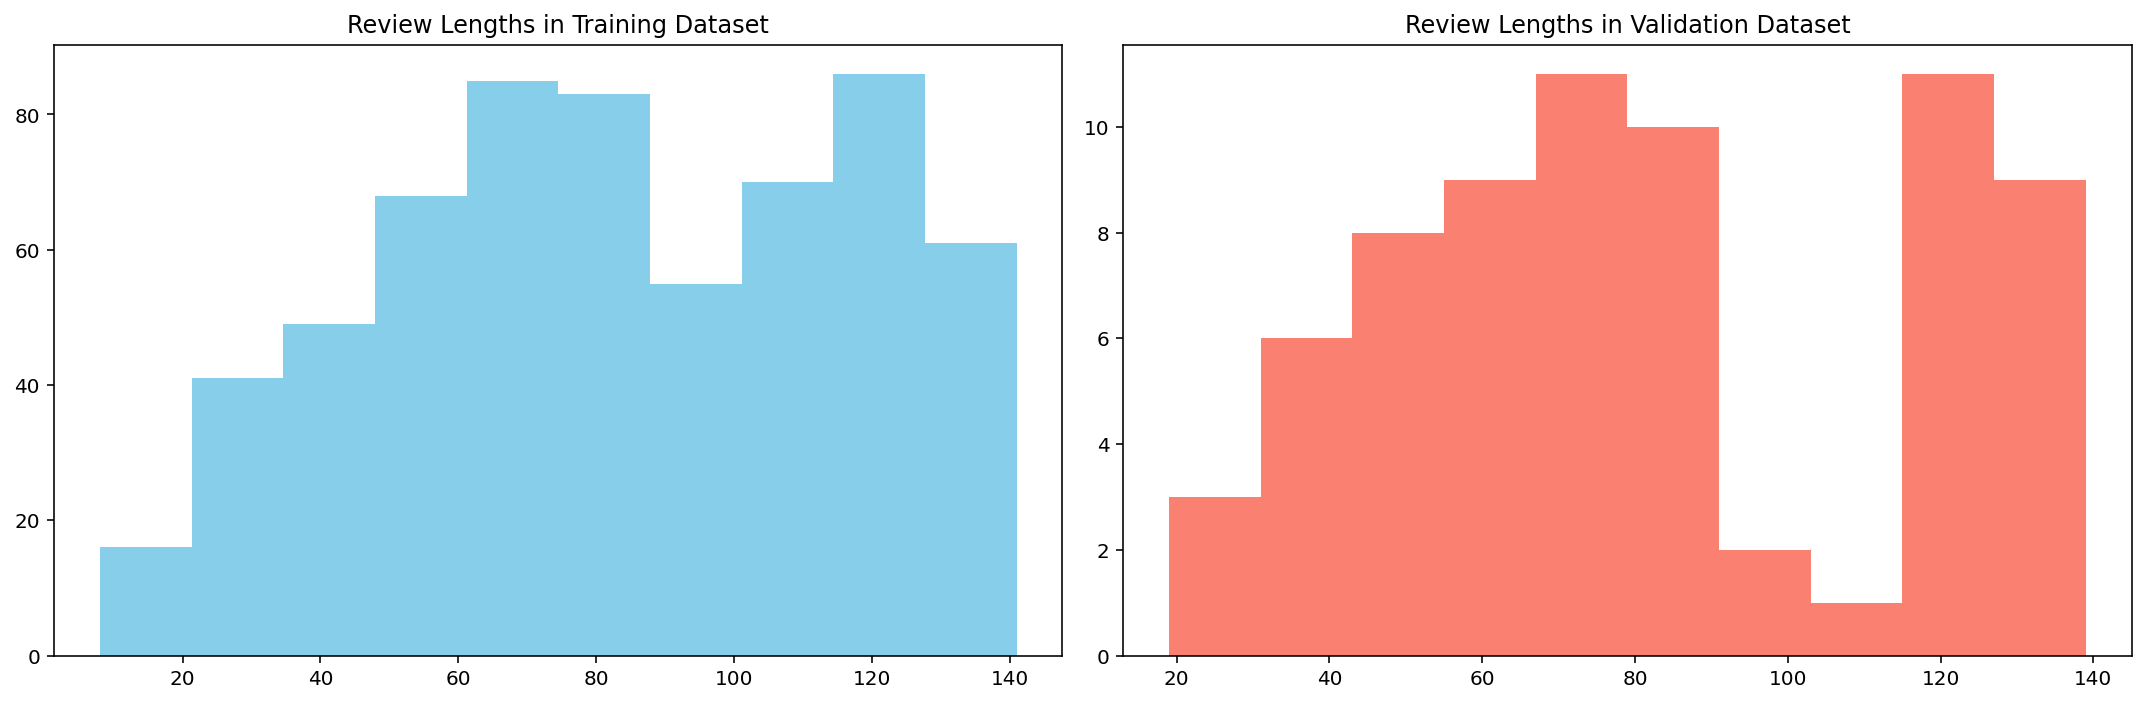

In [10]:
# Get review lengths

train_lengths = [len(review) for review in train_df['text']]
valid_lengths = [len(review) for review in val_df['text']]

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(train_lengths, color = 'skyblue')
axes[0].set_title('Review Lengths in Training Dataset')

axes[1].hist(valid_lengths, color = 'salmon')
axes[1].set_title('Review Lengths in Validation Dataset')

plt.tight_layout()
plt.show()

### Question 1
Examine the visual representations of the dataset. 

<li> Do you notice any trends or patterns? </li> 
<li> Is the dataset balanced in terms of class distribution? </li>
<li> Take a random sample of 10 instances from each class and review their labels. Do you agree/disagree with the labels? </li>
<li> Additionally, analyze the lengths of the text samples. What observations can you make about the distribution of lengths across classes?</li>



3. **Utilize PyTorch datasets to load the data:**
   - Convert the dataset into a format compatible with PyTorch datasets.
   - Implement any necessary preprocessing steps such as tokenization or encoding.
   - Define data loaders for efficient batching and loading during training.

In [11]:
# test_data = pd.read_csv('test_data.csv')
# test_data = pd.read_csv('test_data_unlabeled.csv')
test_data = pd.read_csv('train_data.csv')

In [12]:
# Map the labels to an integer value so that they are compatible with PyTorch datasets

int_to_label = {0: "Negative", 1: "Neutral", 2: "Positive"}
label_to_int = {"Negative": 0, "Neutral":1, "Positive": 2}

train_dict = {'labels':[label_to_int[label] for label in train_df['labels'].to_list()], 'text': train_df['text'].to_list()}
train_ds = Dataset.from_dict(train_dict)

val_dict = {'labels': [label_to_int[label] for label in val_df['labels'].to_list()], 'text': val_df['text'].to_list()}
val_ds = Dataset.from_dict(val_dict)

In [13]:

test_dict = {'labels': [label_to_int[label] for label in test_data['labels'].to_list()], 'text': test_data['text'].to_list()}
test_ds = Dataset.from_dict(test_dict)

In [14]:
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-cased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="longest", truncation=True)

tokenized_training_data = train_ds.map(tokenize_function, batched=True)
tokenized_val_data = val_ds.map(tokenize_function, batched=True)

Map:   0%|          | 0/614 [00:00<?, ? examples/s]

Map:   0%|          | 0/70 [00:00<?, ? examples/s]

In [15]:
tokenized_test_data = test_ds.map(tokenize_function, batched=True)

Map:   0%|          | 0/684 [00:00<?, ? examples/s]

In [16]:
tokenized_training_data = tokenized_training_data.remove_columns(["text"])
tokenized_val_data = tokenized_val_data.remove_columns(["text"])

In [17]:
tokenized_test_data = test_ds.map(tokenize_function, batched=True)

Map:   0%|          | 0/684 [00:00<?, ? examples/s]

In [18]:
tokenized_test_data = tokenized_test_data.remove_columns(["text"])

In [19]:
tokenized_training_data.set_format('torch')
tokenized_val_data.set_format('torch')

In [20]:
tokenized_test_data.set_format('torch')

In [21]:
tokenized_test_data

Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 684
})

In [22]:
train_dataloader = DataLoader(tokenized_training_data, shuffle=True, batch_size=8)
eval_dataloader = DataLoader(tokenized_val_data, batch_size=8)

In [23]:
test_dataloader = DataLoader(tokenized_test_data, batch_size=8)


4. **Perform inference using a pre-existing sentiment analysis model:**
   - Choose a suitable pre-trained sentiment analysis model from the Hugging Face library.
   - Load the model and tokenizer required for inference.
   - Generate predictions for the validation set and evaluate performance metrics.



### Question 2
Hugging Face offers a variety of pre-trained models for sentiment analysis. Choose two models and `justify` your selection for fine-tuning. Consider factors such as model architecture, performance on similar tasks, and computational resources required for training.



In [24]:
base_model = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-cased", num_labels=3, id2label=int_to_label, label2id=label_to_int)

#google-bert/bert-large-cased
#base_model = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-large-cased", num_labels=3, id2label=int_to_label, label2id=label_to_int)

#finiteautomata/bertweet-base-sentiment-analysis
#base_model = AutoModelForSequenceClassification.from_pretrained("finiteautomata/bertweet-base-sentiment-analysis", num_labels=3, id2label=int_to_label, label2id=label_to_int)

Some weights of the model checkpoint at google-bert/bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
device = 'cpu'
metric = evaluate.load("accuracy")
base_model.eval()  # Switch 'base_model' with 'model'

predicted_label = []
true_labels = []

for batch in train_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = base_model(**batch)  # Switch 'base_model' with 'model'

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    predicted_label.extend(predictions.tolist())
    true_labels.extend(batch["labels"].tolist())
    metric.add_batch(predictions=predictions, references=batch["labels"])

accuracy = metric.compute()
print("Accuracy:", accuracy)

Accuracy: {'accuracy': 0.30944625407166126}


In [26]:
min_length = min(len(true_labels), len(predicted_label))

# Confusion matrix
cm = confusion_matrix(true_labels[:min_length], predicted_label[:min_length])
categories = ['Negative', 'Positive', 'Neutral']  # Adjust categories based on your data

print("Confusion Matrix:")
print("True\Predicted\t\t", end="")
for label in categories:
    print(label, end="\t")
print()

for i, row in enumerate(cm):
    print(f"{categories[i]}\t\t", end="")
    for value in row:
        print(value, end="\t\t")
    print()

Confusion Matrix:
True\Predicted		Negative	Positive	Neutral	
Negative		82		0		136		
Positive		42		0		168		
Neutral		78		0		108		


5. **Fine-tune the model:**
   - Decide on the specific parameters or layers to fine-tune based on initial analysis.
   - Implement fine-tuning by updating the selected parameters using a suitable optimization algorithm.
   - Train the model on the training set, monitoring performance on the validation set for early stopping or hyperparameter tuning.

In [27]:
fine_tuned_model = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-cased", num_labels=3, id2label=int_to_label, label2id=label_to_int)

Some weights of the model checkpoint at google-bert/bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
optimizer = AdamW(fine_tuned_model.parameters(), lr=5e-5)

In [29]:
training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch")
metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [30]:
trainer = Trainer(
    model=fine_tuned_model,
    args=training_args,
    train_dataset=tokenized_training_data,
    eval_dataset=tokenized_val_data,
    compute_metrics=compute_metrics,
)

In [31]:
num_epochs = 10
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [32]:
progress_bar = tqdm(range(num_training_steps))

fine_tuned_model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = fine_tuned_model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

  0%|          | 0/770 [00:00<?, ?it/s]

In [33]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****


  Num examples = 614


  Num Epochs = 3


  Instantaneous batch size per device = 8


  Total train batch size (w. parallel, distributed & accumulation) = 8


  Gradient Accumulation steps = 1


  Total optimization steps = 231


  Number of trainable parameters = 108312579


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


***** Running Evaluation *****


  Num examples = 70


  Batch size = 8


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.426175,0.814286


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.426175,0.814286


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.426175,0.814286


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.426175,0.814286


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.426175,0.814286


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.426175,0.814286


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.426175,0.814286


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.426175,0.814286


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.426175,0.814286


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.426175,0.814286


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.426175,0.814286


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.426175,0.814286


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.426175,0.814286


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.426175,0.814286


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.426175,0.814286


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.426175,0.814286


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.426175,0.814286


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.426175,0.814286


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.426175,0.814286


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.426175,0.814286


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.426175,0.814286


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.426175,0.814286


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.426175,0.814286


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.426175,0.814286


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.426175,0.814286


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.426175,0.814286


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.426175,0.814286


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.426175,0.814286


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.426175,0.814286


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.426175,0.814286


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.426175,0.814286


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.426175,0.814286


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.426175,0.814286


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.426175,0.814286


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.426175,0.814286


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.426175,0.814286


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.426175,0.814286


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.426175,0.814286


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.426175,0.814286


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.426175,0.814286


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.426175,0.814286


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.426175,0.814286


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.426175,0.814286


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.426175,0.814286


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.426175,0.814286


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.426175,0.814286


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.426175,0.814286


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.426175,0.814286


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.426175,0.814286


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.426175,0.814286


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.426175,0.814286


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.426175,0.814286


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.426175,0.814286


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.426175,0.814286


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.426175,0.814286


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.426175,0.814286


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.426175,0.814286


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.426175,0.814286


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.426175,0.814286


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.426175,0.814286


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.426175,0.814286


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.426175,0.814286


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.426175,0.814286


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.426175,0.814286


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.426175,0.814286


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.426175,0.814286


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.426175,0.814286


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.426175,0.814286


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.426175,0.814286


6. **Compare results between fine-tuned and baseline:**
   - Evaluate performance metrics such as accuracy, precision, recall, and F1-score for both models.

### Question 4

Conduct a comparative analysis between the performance of pre-trained models and their fine-tuned counterparts for sentiment analysis. The code below computes the accuracy. 

<li> Is accuracy the right metric for this task? </li>
<li> What additional metrics would you compute? Why? </li>


In [34]:
metric = evaluate.load("accuracy")
fine_tuned_model.eval()
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = fine_tuned_model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

metric.compute()

{'accuracy': 0.7857142857142857}

In [35]:
metric = evaluate.load("accuracy")
base_model.eval()
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = base_model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

metric.compute()

{'accuracy': 0.2714285714285714}

In [36]:
metric = evaluate.load("accuracy")
fine_tuned_model.eval()
for batch in test_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = fine_tuned_model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

metric.compute()

{'accuracy': 0.9780701754385965}

In [37]:
metric = evaluate.load("accuracy")
fine_tuned_model.eval()
for batch in test_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = fine_tuned_model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

metric.compute()

{'accuracy': 0.9780701754385965}

In [38]:
# Assuming your test_data DataFrame already has an 'ID' column and the text data for making predictions
# Replace 'test_data = pd.read_csv('train_data.csv')' with the correct loading of your test data
test_data = pd.read_csv('test_data_unlabeled.csv')

# Ensure your model is set to evaluation mode and moved to the appropriate device
fine_tuned_model.eval()
fine_tuned_model.to(device)

# Create a DataLoader for the test dataset
# Make sure your test dataset is properly tokenized and loaded similar to train and validation sets
test_encodings = tokenizer(test_data['text'].tolist(), truncation=True, padding=True, max_length=128)
test_dataset = torch.utils.data.TensorDataset(torch.tensor(test_encodings['input_ids']), torch.tensor(test_encodings['attention_mask']))
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16)

# Generate predictions
predictions = []
with torch.no_grad():
    for input_ids, attention_mask in test_dataloader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        outputs = fine_tuned_model(input_ids, attention_mask=attention_mask)
        pred = torch.argmax(outputs.logits, dim=1)
        predictions.extend(pred.cpu().numpy())

# Map numeric predictions to labels
label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
predicted_labels = [label_map[pred] for pred in predictions]

# Create a DataFrame for submission
submission_df = pd.DataFrame({
    'ID': test_data['ID'].tolist(),  # Ensure 'ID' is the correct column name in your test data
    'TARGET': predicted_labels
})

# Write the DataFrame to a CSV file
submission_file_path = "submission.csv"
submission_df.to_csv(submission_file_path, index=False)
print(f"Submission file created: {submission_file_path}")


Submission file created: submission.csv


References:
- https://github.com/bentrevett/pytorch-sentiment-analysis/blob/main/4%20-%20Transformers.ipynb